In [1]:
import os
from pprint import pprint
import sys
import json

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import pickle

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.data import utils

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

# Mismo criterio de anotación (test subjects in-dataset)

In [2]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}
eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]

### PR by-subject, cheating

```
MASS-SS2-E1SS REDv2-Time (umbral original) F1-score 80.8670 ± 3.5689
MASS-SS2-E1SS REDv2-CWT (umbral original) F1-score 80.9078 ± 3.3566

MASS-SS2-E1SS REDv2-Time (umbral oráculo) F1-score 82.7517 ± 3.0363
MASS-SS2-E1SS REDv2-CWT (umbral oráculo) F1-score 82.8609 ± 2.8293



MASS-SS2-E2SS REDv2-Time (umbral original) F1-score 86.1270 ± 3.3854
MASS-SS2-E2SS REDv2-CWT (umbral original) F1-score 86.1067 ± 3.4184

MASS-SS2-E2SS REDv2-Time (umbral oráculo) F1-score 87.0420 ± 2.9517
MASS-SS2-E2SS REDv2-CWT (umbral oráculo) F1-score 87.1587 ± 2.8882



MASS-MODA REDv2-Time (umbral original) F1-score 78.5749 ± 7.0126
MASS-MODA REDv2-CWT (umbral original) F1-score 78.4800 ± 6.9449

MASS-MODA REDv2-Time (umbral oráculo) F1-score 80.9279 ± 5.8059
MASS-MODA REDv2-CWT (umbral oráculo) F1-score 80.8579 ± 6.0169



INTA-UCH REDv2-Time (umbral original) F1-score 83.8991 ± 4.7945
INTA-UCH REDv2-CWT (umbral original) F1-score 83.5663 ± 5.2646

INTA-UCH REDv2-Time (umbral oráculo) F1-score 84.4179 ± 4.3854
INTA-UCH REDv2-CWT (umbral oráculo) F1-score 84.0723 ± 4.6876
```

In [3]:
metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    
    # Measure performance by subject
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Subject': [], 'Fold': []}
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    for model_name in models:
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            subject_ids = [s for s in subject_ids if s in valid_subjects]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_subject_performance(events_list, detections_list)
            for i, subject_id in enumerate(subject_ids):
                if subject_id in valid_subjects:
                    table['Detector'].append(model_name)
                    table['F1-score'].append(performance['F1-score'][i])
                    table['Recall'].append(performance['Recall'][i])
                    table['Precision'].append(performance['Precision'][i])
                    table['mIoU'].append(performance['mIoU'][i])
                    table['Subject'].append(subject_id)
                    table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    metrics_list.append(table)
print("Done.")


Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
moda, using n= 28

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Done.


In [4]:
# Cheating performance
cheat_thr_df = pd.read_csv('cheating_thresholds.csv')

def get_cheat_thr(dataset_str, model_version, fold_id, subject_id):
    subject_id = str(subject_id)
    row = cheat_thr_df[
        (cheat_thr_df.dataset == dataset_str) 
        & (cheat_thr_df.model == model_version)
        & (cheat_thr_df.fold == fold_id)
        & (cheat_thr_df.subject == subject_id)
    ]
    this_cheat_thr = row.cheat_thr.values.item()
    return this_cheat_thr

In [5]:
metrics_cheat_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            pred_dict[model_version][k] = {}
            for subject_id in fold_subjects:
                if subject_id not in valid_subjects:
                    continue
                subject_cheat_thr = get_cheat_thr(dataset_str, model_version, k, subject_id)
                tmp_dict[k][constants.TEST_SUBSET].set_probability_threshold(subject_cheat_thr)
                subject_predictions = tmp_dict[k][constants.TEST_SUBSET].get_subject_stamps(subject_id)
                pred_dict[model_version][k][subject_id] = subject_predictions
    
    # Measure performance by subject
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Subject': [], 'Fold': []}
    
    for model_name in models:
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            subject_ids = [s for s in subject_ids if s in valid_subjects]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_subject_performance(events_list, detections_list)
            for i, subject_id in enumerate(subject_ids):
                if subject_id in valid_subjects:
                    table['Detector'].append(model_name)
                    table['F1-score'].append(performance['F1-score'][i])
                    table['Recall'].append(performance['Recall'][i])
                    table['Precision'].append(performance['Precision'][i])
                    table['mIoU'].append(performance['mIoU'][i])
                    table['Subject'].append(subject_id)
                    table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    metrics_cheat_list.append(table)
print("Done.")


Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
moda, using n= 28

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Done.


MASS-SS2-E1SS REDv2-Time (umbral original) F1-score 80.8207 ± 3.5765
MASS-SS2-E1SS REDv2-CWT (umbral original) F1-score 80.8357 ± 3.3840
MASS-SS2-E1SS REDv2-Time (umbral oráculo) F1-score 82.7258 ± 3.0348
MASS-SS2-E1SS REDv2-CWT (umbral oráculo) F1-score 82.7870 ± 2.8765
MASS-SS2-E2SS REDv2-Time (umbral original) F1-score 86.1016 ± 3.3743
MASS-SS2-E2SS REDv2-CWT (umbral original) F1-score 86.0852 ± 3.4192
MASS-SS2-E2SS REDv2-Time (umbral oráculo) F1-score 87.0272 ± 2.9507
MASS-SS2-E2SS REDv2-CWT (umbral oráculo) F1-score 87.1330 ± 2.9002
MASS-MODA REDv2-Time (umbral original) F1-score 78.5375 ± 7.0222
MASS-MODA REDv2-CWT (umbral original) F1-score 78.4335 ± 6.9793
MASS-MODA REDv2-Time (umbral oráculo) F1-score 80.7945 ± 5.9283
MASS-MODA REDv2-CWT (umbral oráculo) F1-score 80.7671 ± 6.0817
INTA-UCH REDv2-Time (umbral original) F1-score 83.8783 ± 4.8113
INTA-UCH REDv2-CWT (umbral original) F1-score 83.5430 ± 5.2860
INTA-UCH REDv2-Time (umbral oráculo) F1-score 84.3932 ± 4.4039
INTA-UCH R

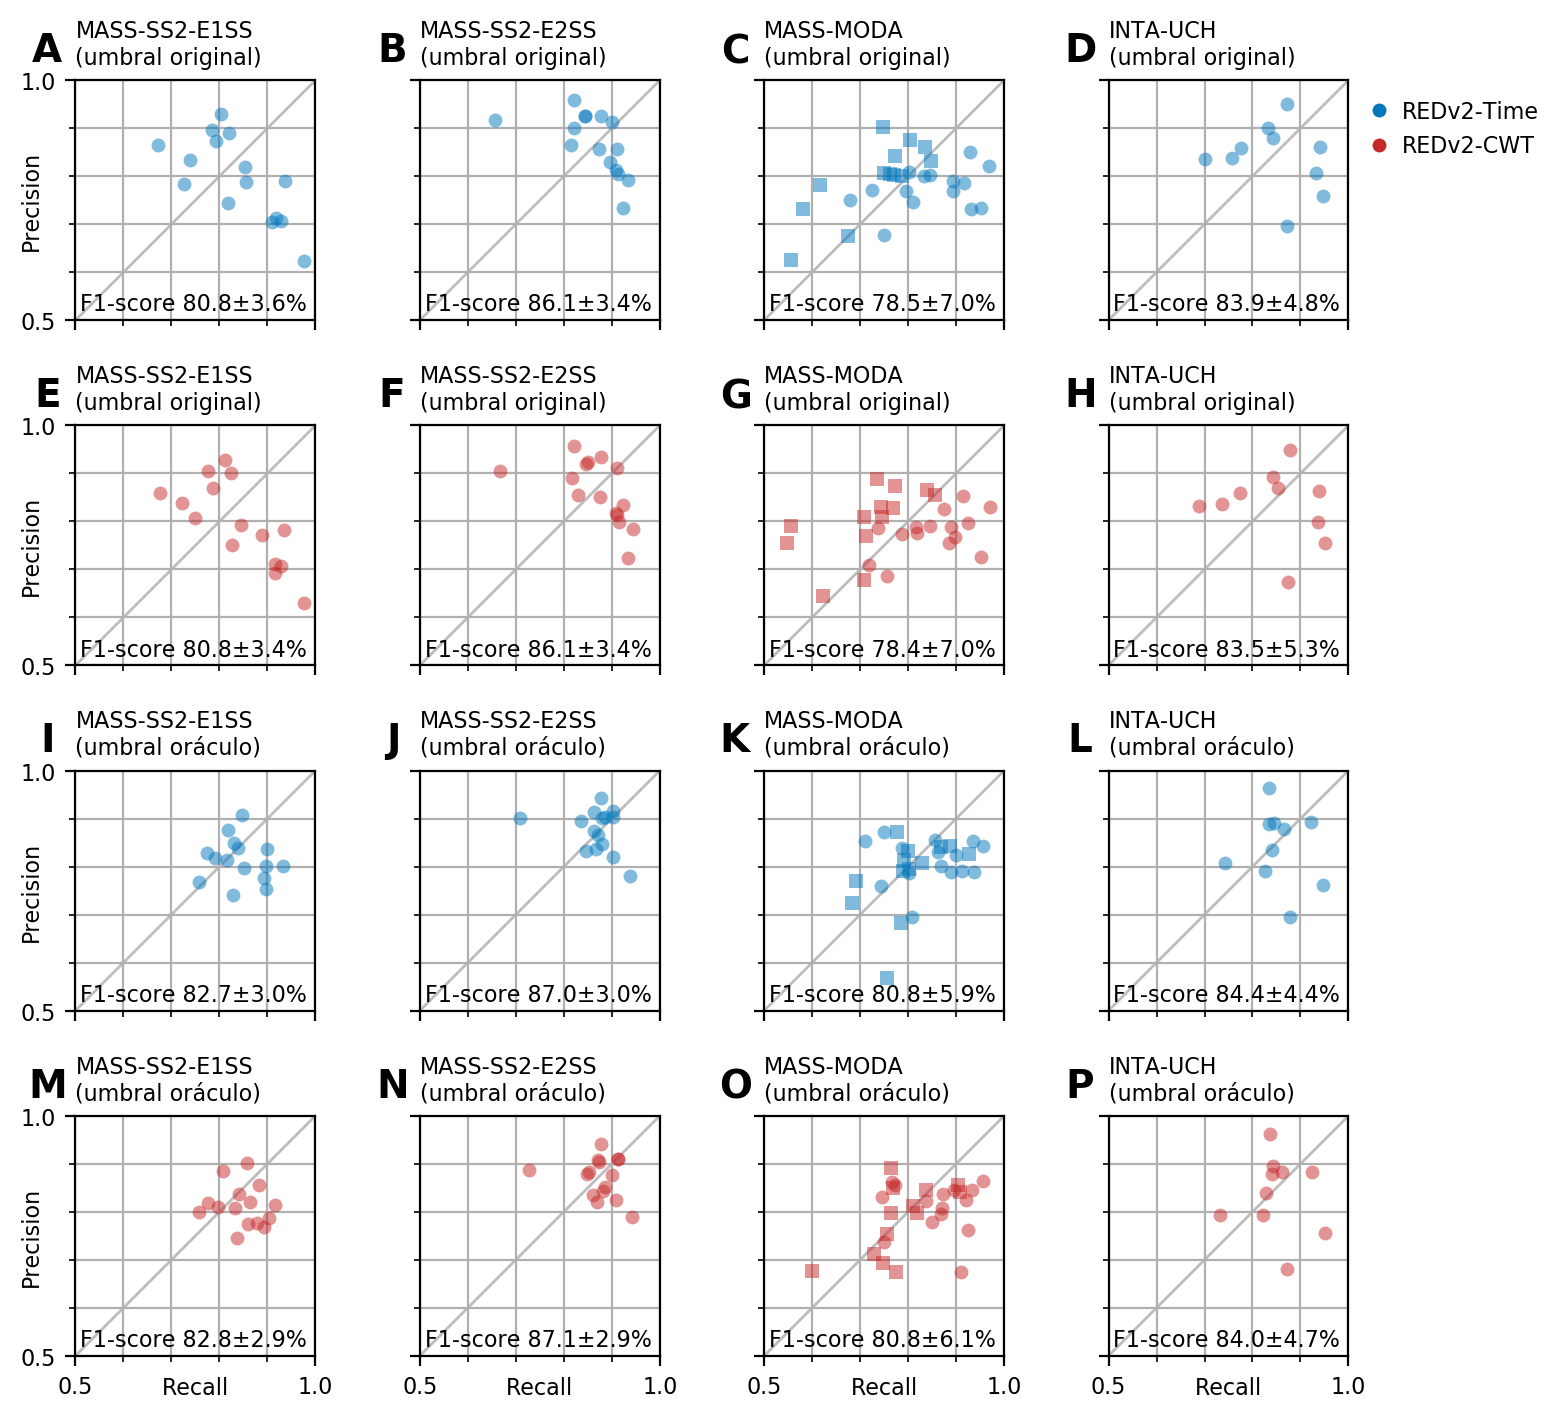

In [6]:
# PR by-subject
save_figure = True

colors = {constants.V2_TIME: viz.PALETTE['blue'], constants.V2_CWT1D: viz.PALETTE['red']}
marker_size = 5
marker_alpha = 0.5
letters = [
    ['A', 'B', 'C', 'D'], 
    ['E', 'F', 'G', 'H'],
    ['I', 'J', 'K', 'L'], 
    ['M', 'N', 'O', 'P'],
]

fig, axes = plt.subplots(4, 4, figsize=(8, 7.2), dpi=200, sharex=True, sharey=True)

for i_config, config in enumerate(eval_configs):
    for i_cheat, m_list in enumerate([metrics_list, metrics_cheat_list]):
        for j, model_version in enumerate(models):
            row_value = j + i_cheat * 2
            col_value = i_config
            ax = axes[row_value, col_value]
            table = m_list[i_config]
            
            model_str = print_model_names[model_version]
            dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
            
            # Form by-subject metrics 
            table_subject = table.drop(columns=["Fold"]).groupby(by=["Detector", "Subject"]).mean().reset_index()  # subject avg

            table_model = table_subject[table_subject['Detector'] == model_version]
            subjects = table_model['Subject'].values
            recalls = table_model['Recall'].values
            precisions = table_model['Precision'].values
            f1_scores = table_model['F1-score'].values
            
            if config['dataset_name'] == constants.MODA_SS_NAME:
                moda = reader.load_dataset(config["dataset_name"], verbose=False)
                phases = [moda.data[sub_id]['phase'] for sub_id in subjects]
                del moda
            else:
                phases = [1 for sub_id in subjects]

            # Draw
            marker_by_phase = {1: 'o', 2: 's'}
            for r, p, ph in zip(recalls, precisions, phases):
                ax.plot(
                    r, p, color=colors[model_version], linestyle='None', alpha=marker_alpha,
                    markeredgewidth=0.0, marker=marker_by_phase[ph], markersize=marker_size)
            ax.plot(
                [], [], color=colors[constants.V2_TIME], linestyle='None', alpha=1.0,
                markeredgewidth=0.0, marker='o', markersize=marker_size, label=print_model_names[constants.V2_TIME])
            ax.plot(
                [], [], color=colors[constants.V2_CWT1D], linestyle='None', alpha=1.0,
                markeredgewidth=0.0, marker='o', markersize=marker_size, label=print_model_names[constants.V2_CWT1D])
            
            cheat_str = '(umbral original)' if i_cheat == 0 else '(umbral oráculo)'
            
            f1_mean = np.mean(f1_scores)
            f1_std = np.std(f1_scores)
            f1_str = '%1.1f\u00B1%1.1f' % (100 * f1_mean, 100 * f1_std)
            
            f1_str_to_plots = 'F1-score %1.4f \u00B1 %1.4f' % (100 * f1_mean, 100 * f1_std)
            print(dataset_str, model_str, cheat_str, f1_str_to_plots)
            
            
            ax.set_title('%s\n%s' % (dataset_str, cheat_str), fontsize=8, loc="left")
            
            ax.text(x=0.51, y=0.51, fontsize=8, s='F1-score %s%%' % f1_str, ha='left', va='bottom')
            
            #ax.set_title('%s en %s' % (model_str, dataset_str), fontsize=8, loc="left")

            if False:
                subjects = table_model['Subject'].values
                print("\n", dataset_str, model_str, cheat_str)
                sorted_locs = np.argsort(precisions)
                for loc in sorted_locs:
                    this_rec = recalls[loc]
                    this_prec = precisions[loc]
                    this_subject = subjects[loc]
                    if this_prec < 0.71 or this_rec < 0.71:
                        if config['dataset_name'] == constants.MODA_SS_NAME:
                            this_phase = phases[loc]
                        else:
                            this_phase = -1
                        print("Subject %s (%d), Recall %1.1f, Precision %1.1f" % (this_subject, this_phase, this_rec * 100, this_prec * 100))

            ax.text(
                x=-0.12, y=1.08, fontsize=14, s=r"$\bf{%s}$" % letters[row_value][col_value],
                ha="center", transform=ax.transAxes)

        
for ax in axes.flatten():
    plotter.format_precision_recall_plot_simple(
        ax, axis_range=(0.5, 1.0), 
        show_quadrants=False, show_grid=True, 
        axis_markers=[0.5, 1], minor_axis_markers=np.arange(0.5, 1 + 0.001, 0.1))
    ax.tick_params(labelsize=8)
    # Get labels closer to axis
    ax.xaxis.labelpad = -8
    ax.yaxis.labelpad = -8

for ax in axes[:, 0]:
    ax.set_ylabel("Precision", fontsize=8)
for ax in axes[-1, :]:
    ax.set_xlabel("Recall", fontsize=8)
    

axes[0, -1].legend(loc='upper left', bbox_to_anchor=(0.95, 1), fontsize=8, frameon=False, handletextpad=0.05)
    
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_transfer_indata_cheat_pr"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

### Outliers

In [ ]:
outliers_dataset = {
    (constants.MASS_SS_NAME, 1): [14],
    (constants.MASS_SS_NAME, 2): [6, 18],
    (constants.MODA_SS_NAME, 1): [
        '01-01-0021', 
        # '01-01-0016', 
        # '01-05-0010', 
        '01-01-0013', 
        # '01-05-0004', 
        '01-01-0017'
    ],
    (constants.INTA_SS_NAME, 1): [3, 10],
}

In [ ]:
# outlier subjects' spectrum in N2
freq_axis = None
spectrums_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    spectrums = {}
    for subject_id in valid_subjects:
        signal = dataset.get_subject_signal(subject_id, normalize_clip=False, which_expert=config["expert"])
        n2_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        signal_valid = signal.reshape(-1, dataset.page_size)[n2_pages].flatten()
        freq_axis, amp_axis = utils.power_spectrum_by_sliding_window(signal_valid, dataset.fs)
        spectrums[subject_id] = amp_axis
    spectrums_list.append(spectrums)
print("Done.")

In [ ]:
def reduce_data_by_band(f, y, f_min=0, f_max=100):
    locs = np.where((f >= f_min) & (f <= f_max))[0]
    f = f[locs]
    y = y[locs]
    return f, y


def get_original_id(dataset_name, custom_id):
    
    NAMES = [
        'ADGU',
        'ALUR',
        'BECA',
        'BRCA',
        'BRLO',
        'BTOL',
        'CAPO',
        'CRCA',
        'ESCI',
        'TAGO'
    ]
    
    if dataset_name == constants.MODA_SS_NAME:
        return custom_id
    elif dataset_name == constants.MASS_SS_NAME:
        return '01-02-%04d' % custom_id
    else:
        return NAMES[custom_id-1]

In [ ]:
save_figure = True

f_min = 4
f_max = 20
color_series = ['blue', 'red', 'green']
letters = ['A', 'B', 'C', 'D']

fig, axes = plt.subplots(1, 4, figsize=(8, 3), dpi=200, sharey=True)
max_y = 0
for i_config, config in enumerate(eval_configs):
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
        
    spectrums = spectrums_list[i_config]
    this_outliers = outliers_dataset[(config["dataset_name"], config["expert"])]
    
    ax = axes[i_config]
    highlight_count = 0
    for subject_id in valid_subjects:
        s = spectrums[subject_id]
        f, s = reduce_data_by_band(freq_axis, s, f_min=f_min, f_max=f_max)
        max_y = max(max_y, s.max())
        if subject_id not in this_outliers:
            ax.plot(f, s, linewidth=0.8, alpha=0.3, color=viz.GREY_COLORS[5], zorder=10)
    
    for i_high, subject_id in enumerate(this_outliers):
        
        # find number of annotations
        events = dataset.get_subject_stamps(subject_id, which_expert=config['expert'], pages_subset='n2')
        n2_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        subject_event_count = events.shape[0]
        subject_density = subject_event_count / (n2_pages.size * dataset.page_duration / 60)
        print("Subject %s, Dataset %s, Events %d, Density %1.2f" % (subject_id, dataset_str, subject_event_count, subject_density))
        
        s = spectrums[subject_id]
        f, s = reduce_data_by_band(freq_axis, s, f_min=f_min, f_max=f_max)
        
        # Here change ids to original (needed for MASS (01-02-etc) and INTA (BECA, TAGO etc))
        subject_id_original = get_original_id(config["dataset_name"], subject_id)
        
        ax.plot(
            f, s, linewidth=1.5, alpha=0.8, zorder=20, color=viz.PALETTE[color_series[i_high]], 
            label="ID %s (%1.1f epm)" % (subject_id_original, subject_density))

    ax.legend(loc="upper right", fontsize=7, handlelength=0.4)
    
    ax.tick_params(labelsize=8)
    ax.set_yticks([])
    ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
    
    title_str = '%s' % dataset_str
    ax.set_title(title_str, fontsize=8, loc="center")
    
    ax.text(
        x=-0.01, y=1.03, fontsize=14, s=r"$\bf{%s}$" % letters[i_config],
        ha="left", transform=ax.transAxes)
    
for ax in axes.flatten():
    ax.set_ylim([0, max_y])
    ax.set_xticks(np.arange(4, 20 + 0.001, 4))
    ax.set_xticks(np.arange(4, 20 + 0.001, 2), minor=True)
    ax.set_xlim([4, 20])
    ax.grid(axis="x", which="minor")

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_transfer_indata_spectra"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

### Fracciones de sujetos válidas
Con al menos un evento, también buscar sujeto más corto. En evernote:

Preparar evolución F1-score: Estudiar si "rho" es % de páginas N2 (relativo a cada sujeto) o número de páginas N2 /minutos (absoluto). Ojalá minutos, para ello hay que estudiar los largos de los sujetos de las bases de interés y cuánto es el mínimo número de minutos para tener algún evento disponible (sobre todo en MASS-SS2-E1SS). Si es %, llegar solo hasta 50%, si es absoluto entonces seria llegar al 50% del sujeto más corto en cada dataset de forma independiente. 

In [ ]:
# find shortest duration 
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    min_pages = 1e5
    for subject_id in valid_subjects:
        this_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        this_data_available = this_pages.size
        min_pages = min(min_pages, this_data_available)
    print("%s: shortest subject has %d N2 pages" % (dataset_str, min_pages))

In [ ]:
# find cumulative distribution of events
fig, axes = plt.subplots(2,2, figsize=(8, 6), dpi=200)
axes = axes.flatten()
for i_config, config in enumerate(eval_configs):
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    min_pages = 1e5
    for subject_id in valid_subjects:
        this_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        this_data_available = this_pages.size
        min_pages = min(min_pages, this_data_available)
    print("%s: shortest subject has %d N2 pages" % (dataset_str, min_pages))
    
    maximum_to_try = min_pages // 2
    
    print("max number of N2 pages to try: %d (%1.2f minutes)" % (maximum_to_try, maximum_to_try * dataset.page_duration / 60))
    
    p_possible = np.arange(1, maximum_to_try + 1)
    all_cumulatives = []
    for subject_id in valid_subjects:
        this_events = dataset.get_subject_stamps(subject_id, which_expert=config['expert'], pages_subset='n2')
        this_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        subject_cumulative_events = []
        for p in p_possible:
            subset_pages = this_pages[:p]
            subset_events = utils.extract_pages_for_stamps(this_events, subset_pages, dataset.page_size)
            n_events = subset_events.shape[0]
            subject_cumulative_events.append(n_events)
        subject_cumulative_events = np.array(subject_cumulative_events)
        all_cumulatives.append(subject_cumulative_events)
    
    # now plot
    p_possible_in_min = p_possible * dataset.page_duration / 60
    ax = axes[i_config]
    for subject_cumulative_events in all_cumulatives:
        ax.plot(p_possible_in_min, subject_cumulative_events, linewidth=0.8, marker='o', markersize=3, alpha=0.8, color=viz.PALETTE['blue'])
    ax.set_ylim([-0.2, 10])
    ax.set_xlim([0, 15])
    ax.set_xticks(np.arange(0, 15.5, 1))
    ax.set_xlabel("N2 minutes", fontsize=8)
    ax.set_ylabel("Acc events", fontsize=8)
    ax.set_title("%s\nmax to try %1.2f N2 min" % (dataset_str, maximum_to_try * dataset.page_duration / 60), fontsize=8)
    ax.tick_params(labelsize=8)
    ax.grid()
plt.tight_layout()

plt.savefig("acc_events_by_n2_minutes_per_subject.pdf")

plt.show()

# Distinto criterio de anotacion

### By-event SS params, different experts

In [ ]:
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MASS_KC_NAME, 1): "MASS-SS2-KC",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}

eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]

table = {
    'Detector': [],
    'Duration': [], 
    'AmplitudePP': [],
    'Frequency': [],
}
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        # process each phase independently
        dataset_str_base = print_dataset_names[(config["dataset_name"], config["expert"])]
        dataset_str_list = [
            '%s-Fase1' %  dataset_str_base,
            '%s-Fase2' %  dataset_str_base,
        ]
        valid_subjects_list = [
            [sub_id for sub_id in dataset.all_ids if dataset.data[sub_id]['phase'] == 1],
            [sub_id for sub_id in dataset.all_ids if dataset.data[sub_id]['phase'] == 2],
        ]
    else:
        dataset_str_list = [print_dataset_names[(config["dataset_name"], config["expert"])]]
        valid_subjects_list = [dataset.all_ids]
    for dataset_str, valid_subjects in zip(dataset_str_list, valid_subjects_list):
        # Retrieve parameters, all events together
        tmp_table = {
            'Duration': [], 
            'AmplitudePP': [],
            'Frequency': [],
        }
        for subject_id in valid_subjects:
            events = dataset.get_subject_stamps(
                subject_id, which_expert=config['expert'], pages_subset=constants.N2_RECORD)
            if events.size == 0:
                continue
            # Duration
            duration = (events[:, 1] - events[:, 0] + 1) / dataset.fs
            tmp_table['Duration'].append(duration)
            # Amplitude
            signal = dataset.get_subject_signal(
                subject_id, normalize_clip=False, which_expert=config['expert'])
            event_name = 'spindle'
            filt_signal = param_filtering_fn(signal, dataset.fs, event_name)
            signal_events = [filt_signal[e[0]:e[1]+1] for e in events]
            amplitude = np.array([param_amplitude_fn(s, dataset.fs, event_name) for s in signal_events])
            tmp_table['AmplitudePP'].append(amplitude)
            # Frequency
            freq_central = np.array([param_frequency_fn(s, dataset.fs) for s in signal_events])
            tmp_table['Frequency'].append(freq_central)
        table['Detector'].append(dataset_str)
        for key in tmp_table.keys():
            table[key].append(np.concatenate(tmp_table[key]))
print("Metrics computed.")

In [ ]:
save_figure = False

print_parameter = {
    'Duration': 'Duración (s)', 'AmplitudePP': 'Amplitud PP ($\mu$V)', 'Frequency': 'Frecuencia (Hz)'
}

min_values_forced = [0, 0, 9]
max_values_forced = [3, 150, 17]
major_ticks_forced = [[0, 1, 2, 3], [0, 50, 100, 150], [9, 11, 13, 15, 17]]
minor_ticks_step_forced = [0.5, 25, 1]

markersize = 8
baseline_color = "k" # viz.GREY_COLORS[6]
experts_specs = {
    "MASS-SS2-E1SS": dict(marker='o', color=baseline_color),
    "MASS-SS2-E2SS": dict(marker='s', color=baseline_color),
    "MASS-MODA-Fase1": dict(marker='^', color=baseline_color),
    "MASS-MODA-Fase2": dict(marker='v', color=baseline_color),
    "INTA-UCH": dict(marker='p', color=baseline_color),
}
letters = ['A', 'B', 'C']
fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200)

param_names = ['Duration', 'AmplitudePP', 'Frequency']
for i_p, param_name in enumerate(param_names):
    ax = axes[i_p]
    model_to_data = {m: d for m, d in zip(table['Detector'], table[param_name])}
    this_order = table['Detector'][::-1]
    x_data_list = [model_to_data[model_name] for model_name in this_order]
    positions = np.arange(len(x_data_list))
    parts = ax.violinplot(
        x_data_list, vert=False, showextrema=False, positions=positions, widths=0.8
    )
    
    for i_pc, pc in enumerate(parts['bodies']):
        pc.set_facecolor(viz.GREY_COLORS[3])
        pc.set_edgecolor(experts_specs[this_order[i_pc]]["color"])
        pc.set_linewidth(0.7)
        pc.set_alpha(1.0)
        pc.set_zorder(20)
    
    for i_data, x_data in enumerate(x_data_list):
        mean_val = x_data.mean()
        model_name = this_order[i_data]
        ax.plot(
            mean_val, i_data, marker="x",#model_specs[model_name]["marker"], 
            color=experts_specs[model_name]["color"], linestyle="None", zorder=30,
            markersize=4)
        low_iqr, high_iqr = np.percentile(x_data, (25, 75))
        ax.plot(
            [low_iqr, high_iqr], [i_data, i_data], linewidth=0.8, zorder=30,
            color=experts_specs[model_name]["color"])

    min_pos_true = min_values_forced[i_p]
    max_pos_true = max_values_forced[i_p]
    for i_model, model_name in enumerate(this_order):
        ax.plot(
            min_pos_true - 0.1 * (max_pos_true - min_pos_true), i_model, 
            markersize=markersize, color=experts_specs[model_name]["color"], zorder=30, markeredgewidth=0.0,
            label=model_name,
            marker=experts_specs[model_name]["marker"], linestyle="None")
    min_pos_lim = min_pos_true - 0.2 * (max_pos_true - min_pos_true)
    ax.set_xlim([min_pos_lim, max_pos_true])
    ax.set_xticks(major_ticks_forced[i_p])
    ax.set_xticks(
        np.arange(
            major_ticks_forced[i_p][0], 
            major_ticks_forced[i_p][-1]+0.001, 
            minor_ticks_step_forced[i_p]
        ), minor=True)
    # ax.set_title("hola", fontsize=8, loc="left")
    ax.tick_params(labelsize=8)
    ax.set_yticks([])
    ax.set_xlabel(print_parameter[param_name], fontsize=8)
    ax.text(
        x=-0.01, y=1.02, fontsize=16, s=r"$\bf{%s}$" % letters[i_p],
        ha="left", transform=ax.transAxes)
    ax.xaxis.set_label_coords(0.6, -0.12)
    ax.grid(axis="x", which="minor")
        
plt.tight_layout()

# Get legend methods
labels_to_lines_dict = {}
for ax in axes:
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = [
    'MASS-SS2-E1SS',
    'MASS-SS2-E2SS',
    'MASS-MODA-Fase1',
    'MASS-MODA-Fase2',
    'INTA-UCH']
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.05), 
    ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_transfer_byevent_params"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)

plt.show()

### Efecto fine-tuning

In [ ]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
    (constants.CAP_SS_NAME, 1): "CAP-A7",
}

target_config = dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3)
source_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.CAP_SS_NAME, expert=1, strategy='5cv', seeds=1),
]

print("\nLoading target:", target_config)
dataset = reader.load_dataset(target_config["dataset_name"], verbose=False)
average_mode = constants.MICRO_AVERAGE if (target_config["dataset_name"] == constants.MODA_SS_NAME) else constants.MACRO_AVERAGE

metrics_list = []
for source_config in source_configs:
    print("\nLoading source:", source_config)

    pred_dict = {}
    for model_version in models:
        pred_dict[model_version] = {}
        tmp_sizes_dict = fig_utils.get_red_predictions_for_moda_sizes(
            model_version,
            dataset,
            source_dataset_name=source_config['dataset_name'],
            source_expert=source_config['expert'],
            overwrite_thr_with_constant=True,
            verbose=True)
        for size in tmp_sizes_dict.keys():
            pred_dict[model_version][size] = {}
            tmp_dict = tmp_sizes_dict[size]
            # Retrieve only predictions, same format as baselines
            for k in tmp_dict.keys():
                fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
                fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
                pred_dict[model_version][size][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}

    # Measure performance by subject (note that, independent from fraction, test sets are always complete)
    _, _, test_ids_list = get_partitions(dataset, target_config["strategy"], target_config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'Fracción': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Fold': []}
    for k in range(n_folds):
        subject_ids = test_ids_list[k]
        feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=target_config["expert"])
        events_list = feed_d.get_stamps()
        for model_version in models:
            for size in tmp_sizes_dict.keys():
                detections_list = [pred_dict[model_version][size][k][subject_id] for subject_id in subject_ids]
                performance = fig_utils.compute_fold_performance(events_list, detections_list, average_mode)
                table['Detector'].append(model_version)
                table['Fracción'].append(size)
                table['F1-score'].append(performance['F1-score'])
                table['Recall'].append(performance['Recall'])
                table['Precision'].append(performance['Precision'])
                table['mIoU'].append(performance['mIoU'])
                table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    metrics_list.append(table)
print("Done.")

In [ ]:
table = metrics_list[0]
table.groupby(by=["Detector", "Fracción"]).mean().drop(columns=["Fold"])

In [ ]:
table = metrics_list[1]
table.groupby(by=["Detector", "Fracción"]).mean().drop(columns=["Fold"])

In [ ]:
table = metrics_list[2]
table.groupby(by=["Detector", "Fracción"]).mean().drop(columns=["Fold"])

In [ ]:
# draw
save_figure = False

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colors_dict = {
    constants.MODA_SS_NAME: 'blue',
    constants.MASS_SS_NAME: 'red',
    constants.CAP_SS_NAME: 'green'
}
show_std = False
std_is_bar = False
show_dosed_baseline = True
dosed_metrics_reference = {'F1-score': (77.5,1.7), 'Recall': (76.4, 2.8), 'Precision': (78.9, 3.0), 'mIoU': (71.4, 1.1)}

fig, axes = plt.subplots(2, 4, figsize=(8, 4), dpi=200, sharex=True, sharey=True)
metric_order = ['F1-score', 'Recall', 'Precision', 'mIoU']
for i_model, model_version in enumerate(models):
    for i_m, metric_name in enumerate(metric_order):
        ax = axes[i_model, i_m]
        for i_config, source_config in enumerate(source_configs):
            table = metrics_list[i_config]
            table = table[table['Detector'] == model_version]
            table = table[['Fracción', metric_name, 'Fold']]
            table_mean = table.groupby(by=['Fracción']).mean().reset_index().to_dict(orient='list')
            table_std = table.groupby(by=['Fracción']).std(ddof=0).reset_index().to_dict(orient='list')
            sizes_list = table_mean['Fracción']
            sizes_list = np.array([float(s) for s in sizes_list])
            sorted_locs = np.argsort(sizes_list)
            sizes_list = sizes_list[sorted_locs] / 100
            mean_list = np.array(table_mean[metric_name])[sorted_locs]
            std_list = np.array(table_std[metric_name])[sorted_locs]
            
            dataset_str = print_dataset_names[(source_config['dataset_name'], source_config['expert'])]
            if dataset_str == 'MASS-MODA':
                label_str = 'Sin pre-entrenamiento'
            else:
                label_str = 'Pre-entrenado en %s' % dataset_str
            this_color_str = colors_dict[source_config['dataset_name']]
            
            if show_std and std_is_bar:
                ax.errorbar(
                    sizes_list, mean_list, yerr=std_list, label=label_str, 
                    linewidth=1, marker='o', markersize=3, 
                    color=viz.PALETTE[this_color_str],
                    capsize=1.5, alpha=.8, zorder=20,
                )
            elif show_std and not std_is_bar:
                ax.plot(
                    sizes_list, mean_list, 
                    label=label_str,
                    linewidth=1, marker='o', markersize=3, 
                    color=viz.PALETTE[this_color_str],
                    alpha=.8, zorder=20,
                )
                ax.fill_between(
                    sizes_list, 
                    mean_list + std_list,
                    mean_list - std_list,
                    facecolor=viz.PALETTE[this_color_str], alpha=0.4, zorder=20,
                )
            else:
                ax.plot(
                    sizes_list, mean_list, 
                    label=label_str,
                    linewidth=1, marker='o', markersize=3, 
                    color=viz.PALETTE[this_color_str],
                    alpha=.8, zorder=20,
                )
        if show_dosed_baseline:
            metric_tuple = dosed_metrics_reference[metric_name]
            dosed_mean = metric_tuple[0] / 100
            ax.axhline(dosed_mean, linewidth=.8, linestyle="--", color="k", label="DOSED", zorder=5)

        model_str = print_model_names[model_version]
        ax.set_title('%s, %s' % (model_str, metric_name), fontsize=8, loc="left")

y_max = 0.9
y_min = 0.7
        
for i_ax, ax in enumerate(axes.flatten()):
    # ax.legend(loc="lower right", fontsize=8)
    ax.tick_params(labelsize=8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticks(np.arange(0, 1+0.001, 0.1), minor=True)
    
    ax.set_ylim([y_min, y_max])
    ax.set_yticks(np.arange(y_min, y_max+0.001, 0.1))
    ax.set_yticks(np.arange(y_min, y_max+0.001, 0.05), minor=True)
    
    ax.grid(which="minor")
    
    if i_ax >= 4:
        ax.set_xlabel("Fracción de señales", fontsize=8)
    
    ax.text(
        x=-0.08, y=1.05, fontsize=16, s=r"$\bf{%s}$" % letters[i_ax],
        ha="center", transform=ax.transAxes)

# outside legend, bottom, center
# Get legend methods
labels_to_lines_dict = {}
for ax in axes.flatten():
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        lin.set_alpha(1.0)
        labels_to_lines_dict[lbl] = lin
labels = list(labels_to_lines_dict.keys())
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.03), ncol=len(labels), frameon=False, handletextpad=0.5)

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_transfer_finetune_sizes"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.4)

plt.show()

In [ ]:
# Table for latex, only F1-score
metric_name = 'F1-score'

print("Fracción de    & Datos de          & \multicolumn{2}{c}{F1-score (\%)} \\\\")
print("señales (\%)  & pre-entrenamiento & REDv2-Time & REDv2-CWT           \\\\")

rows_list = []
for i_config, source_config in enumerate(source_configs):
    dataset_str = print_dataset_names[(source_config['dataset_name'], source_config['expert'])]
    
    metrics_by_model = {}
    for i_model, model_version in enumerate(models):
        table = metrics_list[i_config]
        table = table[table['Detector'] == model_version]
        table = table[['Fracción', metric_name, 'Fold']]
        table_mean = table.groupby(by=['Fracción']).mean().reset_index().to_dict(orient='list')
        table_std = table.groupby(by=['Fracción']).std(ddof=0).reset_index().to_dict(orient='list')
        sizes_list = table_mean['Fracción']
        sizes_list = np.array([float(s) for s in sizes_list])
        sorted_locs = np.argsort(sizes_list)
        sizes_list = sizes_list[sorted_locs] / 100
        mean_list = np.array(table_mean[metric_name])[sorted_locs]
        std_list = np.array(table_std[metric_name])[sorted_locs]
        metric_str_list = ['$%1.1f\pm %1.1f$' % (100 * t_mean, 100 * t_std) for t_mean, t_std in zip(mean_list, std_list)]
        metrics_by_model[model_version] = metric_str_list
        
    n_sizes = len(sizes_list)
    for i_size in range(n_sizes):
        pretrain_str = '-' if dataset_str == 'MASS-MODA' else dataset_str
        row_str = '%d & %s & %s & %s \\\\' % (
            100 * sizes_list[i_size], pretrain_str.ljust(15), 
            metrics_by_model[constants.V2_TIME][i_size], 
            metrics_by_model[constants.V2_CWT1D][i_size])
        rows_list.append(row_str)
    
rows_list = np.sort(rows_list)
for row in rows_list:
    print(row)